In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#change the path when you run it 
claims = pd.read_csv("/Applications/datathon/Datathon2020data/claims.csv")

###  data prep

In [3]:
##Check missing val and ensure no categorical var
# claims.isna().any()
# claims.info()

In [5]:
#small fix
claims['Age'] = claims['Age']//365
claims['Is_Dead'] = np.where(claims['Death_age'].isna(), False, True)
claims['DeductibleAmt'] = np.where(claims['DeductibleAmt'].isna(), 0, claims['DeductibleAmt'])

In [6]:
claims['InpatientAnnualDeductibleAmt'] = np.where(claims['InpatientAnnualDeductibleAmt']==0,0,1)

In [7]:
#Single grouping - amount less than 500
claims['OutpatientAnnualDeductibleAmt'] = np.where(claims['OutpatientAnnualDeductibleAmt']<=500,0,1)

In [8]:
claims['DeductibleAmt'] = np.where(claims['DeductibleAmt']==0, 0, 1)

In [8]:
### TO-DO: split reimbursement amount into groups

In [10]:
df = claims.drop(['Death_age'], axis=1)

In [62]:
df = df[df['Fraud']==1]
df.dtypes

AmtReimbursed                       int64
DeductibleAmt                       int64
Is_inpatient                        int64
Fraud                               int64
Gender                              int64
Race                                int64
RenalDisease                        int64
State                               int64
County                              int64
InpatientAnnualReimbursementAmt     int64
InpatientAnnualDeductibleAmt        int64
OutpatientAnnualReimbursementAmt    int64
OutpatientAnnualDeductibleAmt       int64
NumOfClaimDays                      int64
Age                                 int64
DiagnosisCode_Num                   int64
ProcedureCode_Num                   int64
ChronicDisease_Num                  int64
PhysiciansNum                       int64
AdmitDiagnosInDiagnos                bool
FullYearPlanA                        bool
FullYearPlanB                        bool
Is_Dead                              bool
dtype: object

### K Means

In [275]:
data = claims.drop(['Death_age'], axis=1)
X = data.drop(['Fraud'], axis=1)
Y = np.array(data['Fraud'])
X.isna().sum()

AmtReimbursed                       0
DeductibleAmt                       0
Is_inpatient                        0
Gender                              0
Race                                0
RenalDisease                        0
State                               0
County                              0
InpatientAnnualReimbursementAmt     0
InpatientAnnualDeductibleAmt        0
OutpatientAnnualReimbursementAmt    0
OutpatientAnnualDeductibleAmt       0
NumOfClaimDays                      0
Age                                 0
DiagnosisCode_Num                   0
ProcedureCode_Num                   0
ChronicDisease_Num                  0
PhysiciansNum                       0
AdmitDiagnosInDiagnos               0
FullYearPlanA                       0
FullYearPlanB                       0
Is_Dead                             0
dtype: int64

In [276]:
from sklearn.cluster import KMeans

kms = KMeans(n_clusters=2, init='k-means++',
             n_init=10, random_state=123)

y_fit = kms.fit_predict(X)
centroids = kms.cluster_centers_
y_fit

array([1, 1, 0, ..., 0, 0, 0], dtype=int32)

In [277]:
kmeans = pd.DataFrame(y_fit)
kmean = np.where(kmeans == 1, "1", "0")
kmean

array([['1'],
       ['1'],
       ['0'],
       ...,
       ['0'],
       ['0'],
       ['0']], dtype='<U1')

In [278]:
X.insert((X.shape[1]),'kmeans',kmean)  

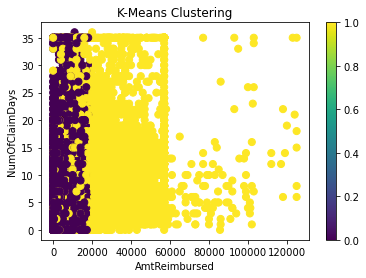

In [279]:
## Visualize...
# color = map(lambda x:colorama[x+1], Y)
# color1 = list(color)
# plt.scatter(X,Y, c=y_fit, alpha = 0.5, edgecolor = 'k')
# for idx, centroid in enumerate(centroids):
#     plt.scatter(*centroid, color = colorama[idx+1])

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X['AmtReimbursed'],X['NumOfClaimDays'],
                     c=kmeans,s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('AmtReimbursed')
ax.set_ylabel('NumOfClaimDays')
plt.colorbar(scatter)

In [280]:
## Other unsupervised clustering to try
#IsolationForest 
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

X = data.drop(['Fraud'], axis=1)
Y = np.array(data['Fraud'])
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.3, random_state=123)
iso = IsolationForest(contamination=0.1, random_state=123)
iso_pred = iso.fit_predict(X_train)

In [281]:
print(len(X_train))
print(len(iso_pred))

390747
390747


In [252]:
# mask = iso_pred==-1
# mask = mask.tolist()
# X_train, y_train = X_train.iloc[mask], y_train[mask]
# yhat = iso.predict(X_test)
# mse = mean_squared_error(y_test, yhat)

In [284]:
X_iso_train = X_train
y_iso_train = y_train
X_iso_train['iso_pred'] = iso_pred
X_iso_train_outliers = X_iso_train[X_iso_train['iso_pred'] == -1]
Y_iso_train_outliers = y_iso_train[X_iso_train['iso_pred'] == -1]
Y_iso_train_outliers.sum()
outlier_Fraud = Y_iso_train_outliers.sum()/len(X_iso_train_outliers)
print('The possibility that ouliers are fraud is {}'.format(outlier_Fraud))

The possibility that ouliers are fraud is 0.5154958413307742


/Users/joy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [285]:
# compute accuracy
y_result = iso_pred - y_train
y_result = y_result.tolist()
train_accuracy = (y_result.count(-2)+y_result.count(1))/len(y_result)
train_accuracy

0.6223515471647895

# OneClassSVM

In [ ]:
# OneClassSVM 
from sklearn.svm import OneClassSVM 
train, test = train_test_split(data, test_size=.2) 
train_normal = train[train['Fraud']==0] 
train_outliers = train[train['Fraud']==1] 
outlier_prop = len(train_outliers) / len(train_normal) 
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.01) 
svm_pred = svm.fit_predict(train)

In [ ]:
X_svm_train = train.drop('Fraud',axis=1)
y_svm_train = train['Fraud']
X_svm_train['svm_pred'] = svm_pred
X_svm_train_outliers = X_svm_train[X_svm_train['iso_pred'] == -1]
Y_svm_train_outliers = y_iso_train[X_svm_train['iso_pred'] == -1]
Y_svm_train_outliers.sum()
outlier_Fraud = Y_svm_train_outliers.sum()/len(X_svm_train_outliers)
print('The possibility that ouliers are fraud is {}'.format(outlier_Fraud))

# LocalOutlierFactor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=2)
lof_pred = lof.fit_predict(X)
X_lof = X
X_lof['lof_pred'] = lof_pred
X_lof['negative_outlier_factor'] = lof.negative_outlier_factor_

In [228]:
X_outliers = X_lof[X_lof['lof_pred'] == -1]
Y_outliers = Y[X_lof['lof_pred'] == -1]
Y_outliers.sum()
outlier_Fraud = len(X_outliers)/Y_outliers.sum()
print('The possibility that ouliers are fraud is {}'.format(outlier_Fraud))

The possibility that ouliers are fraud is 1.0


In [229]:
#Test on Fraud data
fraud = data[data['Fraud'] == 1]
X_fraud = fraud.drop(['Fraud'], axis=1)
Y_fraud = np.array(fraud['Fraud'])
lof_fraud = LocalOutlierFactor(n_neighbors=20)
lof_pred_fraud = lof_fraud.fit_predict(X_fraud)

In [231]:
X_fraud['lof_pred_fraud'] = lof_pred_fraud
X_fraud['negative_outlier_factor'] = lof_fraud.negative_outlier_factor_

In [234]:
X_real_fraud = X_fraud[X_fraud['lof_pred_fraud'] == -1]
X_real_fraud.describe()

,AmtReimbursed,DeductibleAmt,Is_inpatient,Gender,Race,RenalDisease,State,County,InpatientAnnualReimbursementAmt,InpatientAnnualDeductibleAmt,OutpatientAnnualReimbursementAmt,OutpatientAnnualDeductibleAmt,NumOfClaimDays,Age,DiagnosisCode_Num,ProcedureCode_Num,ChronicDisease_Num,PhysiciansNum,lof_pred_fraud,negative_outlier_factor
count,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.000000,2538.0,2538.000000
mean,4673.806147,0.326241,0.305359,1.555162,1.314815,0.281718,24.518519,389.689519,16388.065406,0.888495,4257.568952,0.427502,3.416470,70.545705,4.420804,0.273444,5.681639,1.628842,-1.0,-1.935695
std,12879.402895,0.468929,0.460650,0.497046,0.822779,0.449925,15.363647,299.018101,25667.326457,0.314819,10350.999375,0.494814,6.244045,16.072108,3.247666,0.597667,2.339424,0.631073,0.0,0.794542
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-500.000000,0.000000,-60.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,-1.0,-15.460533
25%,60.000000,0.000000,0.000000,1.000000,1.000000,0.000000,10.000000,140.000000,2000.000000,1.000000,330.000000,0.000000,0.000000,65.000000,2.000000,0.000000,4.000000,1.000000,-1.0,-1.951982
50%,200.000000,0.000000,0.000000,2.000000,1.000000,0.000000,23.000000,331.000000,7700.000000,1.000000,1470.000000,0.000000,0.000000,73.000000,3.000000,0.000000,5.000000,2.000000,-1.0,-1.683993
75%,3000.000000,1.000000,1.000000,2.000000,1.000000,1.000000,37.000000,600.000000,16780.000000,1.000000,3915.000000,1.000000,4.000000,82.000000,8.000000,0.000000,7.000000,2.000000,-1.0,-1.568124
max,125000.000000,1.000000,1.000000,2.000000,5.000000,1.000000,54.000000,999.000000,161470.000000,1.000000,102960.000000,1.000000,35.000000,101.000000,10.000000,4.000000,11.000000,3.000000,-1.0,-1.500108
